# Contextual Bayesian Optimisation via Large Language Models

This notebook will execute Contextual Bayesian Optimisation, in attempt to detect whether LLMs can learn contextual information.

<DIV STYLE="background-color:#000000; height:10px; width:100%;">

# Import Libraries

In [2]:
# Standard Library
import os
import copy
import pickle
import random 

# Third Party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Private
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
from model import CEBO

In [2]:
# Default OpenAI API Key
os.environ["OPENAI_API_KEY"] = ""

# Data Preparation

The dataset can be found here [BigSOL](https://zenodo.org/record/6809669). We use this for contextual BO as we are provided with varying context, for the same compound and solute. In the original BO setup of BO-LIFT, we want to remove points because there is no context and the goal is to obtain the values of as many new points as possible to find the maximum. In the contextual BO setup, the goal is different - we want to choose the appropriate point for the current context, which can be anything from the pool.

In [3]:
# Read your data into a DataFrame
data = pd.read_csv("../cebo/data/bigsoldb.csv")
data = data.dropna()
data = data.drop_duplicates().reset_index(drop=True)
data.rename(columns={'T,K': 'Temperature'}, inplace=True)
data = data.sort_values(by="SMILES")
# Shrink dataset
main_data = pd.DataFrame(columns=["SMILES"]+list(data["Temperature"].unique()))
for smile in data["SMILES"].unique():
    sub_result = data[data["SMILES"]==smile]
    sub_temp = {"SMILES": smile}
    sub_temp.update(dict(sub_result["Temperature"].value_counts()))
    for temp in list(main_data.columns):
        if temp not in sub_temp.keys():
            sub_temp[temp] = 0
    main_data = pd.concat((pd.DataFrame([sub_temp], columns=list(main_data.columns)), main_data))

In [4]:
# Return smaller compound list
sub_data = main_data.iloc[:, :6]
mask = (sub_data.iloc[:, 1:] > 3) & (sub_data.iloc[:, 1:] < 6)
mask = mask.all(axis=1)
refined_data = sub_data[mask]
refined_data = refined_data[refined_data.iloc[:, 1:].eq(5).all(axis=1)]
refined_data = refined_data[refined_data['SMILES'].apply(lambda x: len(x) < 30)][:4]
combined_data = data.merge(refined_data['SMILES'], on='SMILES')
combined_data = combined_data[combined_data['Temperature'].isin(list(main_data.iloc[:, :6].columns)[1:])]
# Final dataframe
combined_data.rename(columns={'SMILES_Solvent': 'SMILES Solvent'}, inplace=True)
combined_df = combined_data[["SMILES", "Temperature", "SMILES Solvent", "Solubility"]]
combined_df

,SMILES,Temperature,SMILES Solvent,Solubility
0,O=C(O)c1ccc(O)c(O)c1,293.15,CCOC(C)=O,0.004780
2,O=C(O)c1ccc(O)c(O)c1,313.15,O,0.002442
3,O=C(O)c1ccc(O)c(O)c1,308.15,CO,0.092980
4,O=C(O)c1ccc(O)c(O)c1,313.15,CO,0.126110
6,O=C(O)c1ccc(O)c(O)c1,313.15,CCO,0.084650
...,...,...,...,...
159,OCC(CO)(CO)CO,293.15,O,0.008417
160,OCC(CO)(CO)CO,313.15,O,0.015350
163,OCC(CO)(CO)CO,313.15,CC#N,0.000129
164,OCC(CO)(CO)CO,308.15,CC#N,0.000102


In [6]:
# Clean and store data
bigsoldb_df = pd.read_csv("../cebo/data/bigsoldb.csv")
bigsoldb_df = bigsoldb_df.dropna()
bigsoldb_df = bigsoldb_df.drop_duplicates().reset_index(drop=True)
bigsoldb_df.rename(columns={'T,K': 'Temperature'}, inplace=True)
bigsoldb_df = bigsoldb_df.sort_values(by="SMILES")
bigsoldb_df = bigsoldb_df.iloc[:, :-1]
# Filter by SMILES counts
counts = bigsoldb_df["SMILES"].value_counts()[::-1]
filt = counts[(counts >= 10) & (counts <= 50)].index
bigsoldb_df = bigsoldb_df[bigsoldb_df["SMILES"].isin(filt)]
# Filter by SMILES counts
new_counts = bigsoldb_df["SMILES"].value_counts()[::-1]
mask = new_counts.cumsum() <= 200
filt = mask[mask == True].index
bigsoldb_df = bigsoldb_df[bigsoldb_df["SMILES"].isin(filt)]
# Filter by Temperature counts
new_counts = bigsoldb_df["Temperature"].value_counts()
mask = new_counts.cumsum() <= 200
filt = mask[mask == True].index
bigsoldb_df = bigsoldb_df[bigsoldb_df["Temperature"].isin(filt)]
# Final dataframe
bigsoldb_df.rename(columns={'SMILES_Solvent': 'SMILES Solvent'}, inplace=True)
bigsoldb_df = bigsoldb_df[["SMILES", "Temperature", "SMILES Solvent", "Solubility"]]
bigsoldb_df

,SMILES,Temperature,SMILES Solvent,Solubility
31283,Br.CC(C)c1ccc(NC2=NCCC3(CCCCC3)[Se]2)cc1,313.15,CCCCCCCCO,0.083100
48635,Br.CC(C)c1ccc(NC2=NCCC3(CCCCC3)[Se]2)cc1,308.15,CCCCCC,0.000009
48634,Br.CC(C)c1ccc(NC2=NCCC3(CCCCC3)[Se]2)cc1,303.15,CCCCCC,0.000007
48633,Br.CC(C)c1ccc(NC2=NCCC3(CCCCC3)[Se]2)cc1,298.15,CCCCCC,0.000006
48632,Br.CC(C)c1ccc(NC2=NCCC3(CCCCC3)[Se]2)cc1,293.15,CCCCCC,0.000005
...,...,...,...,...
41649,O=S(=O)([O-])c1cccc2ccccc12.[Na+],298.15,O,0.012558
41651,O=S(=O)([O-])c1cccc2ccccc12.[Na+],308.15,O,0.014130
41652,O=S(=O)([O-])c1cccc2ccccc12.[Na+],313.15,O,0.015162
41653,O=S(=O)([O-])c1cccc2ccccc12.[Na+],318.15,O,0.016876


# ICL Contextual Bayesian Optimisation Experiment

In [44]:
# Helper functions
def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))
                      
def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)

def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)
  
def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

def find_target(data, x_start, target):
    matching_index = (data.iloc[:, :-1] == x_start).all(axis=1)
    pos = matching_index[matching_index].index[0]
    y_start = data.loc[pos][target]
    return y_start

def find_experiment(data, result, context, t):
    result_summary = {key: value for key, value in result[0][0].items() if key != "Temperature"}
    sub_results = data[(data[list(result_summary)] == pd.Series(result_summary)).all(axis=1)]
    return data.loc[abs(sub_results[context] - t).idxmin()].to_dict()


In [45]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment_cebo_lift(model_1, model_2, data, indexes,
                             context, target,
                             N=10, initial_train=1, aq="random", start_index=0):
    # Acquisition function random
    if aq == 'random_mean':
        return [(i, expected_value_q(i, 100, data[target])) for i in range(1, N + 1)]
    # Tell
    for i in indexes[:initial_train]:
        example_1 = data.iloc[i, :][["SMILES", "SMILES Solvent"] + [target]]
        model_1.tell(example_1.to_dict())
        example_2 = data.iloc[i, :][["SMILES", "SMILES Solvent"] + [context] + [target]]
        model_2.tell(example_2.to_dict())
    # Create pool
    bo_pool = [data.iloc[i, :][["SMILES", "SMILES Solvent"]].to_dict() for i in indexes]
    cbo_pool = [data.iloc[i, :][["SMILES", "SMILES Solvent"] + [context]].to_dict() for i in indexes]
    # Start point
    x_start = cbo_pool[start_index]
    # Obtain function output of start point
    y_start = find_target(data=data, x_start=x_start, target=target)
    # Tell
    x_copy_bo = x_start.copy()
    x_copy_cbo = x_start.copy()
    x_copy_bo.pop("Temperature")
    x_copy_bo.update({f"{target}": y_start})
    x_copy_cbo.update({f"{target}": y_start})
    model_1.tell(x_copy_bo)
    model_2.tell(x_copy_cbo)
    # Store regret
    f_t_max = data[data["Temperature"] == x_start["Temperature"]]["Solubility"].max()
    regret_bo_t = {0: {"Regret": f_t_max - y_start, "Parameter": x_copy_cbo, "Temperature": x_start["Temperature"]}}
    regret_cbo_t = {0: {"Regret": f_t_max - y_start, "Parameter": x_copy_cbo, "Temperature": x_start["Temperature"]}}
    # Initialise Bayesian Optimisation (BO) and Contextual Bayesian Optimisation (C-BO)
    for i in range(1, N):
        # Uniformly sample t ~ T (from pool)
        t = random.choice(data["Temperature"].tolist())
        # Remask the temperature of the pool candidates
        for j, ele in enumerate(cbo_pool):
            ele["Temperature"] = t
            cbo_pool[j] = ele
        # BO
        result_bo = model_1.ask(bo_pool, aq_fxn=aq, _lambda=1.0)
        # C-BO
        result_cbo = model_2.ask(cbo_pool, aq_fxn=aq, _lambda=1.0)
        # Match the temperature sampled with the closest temperature in the pool for BO and C-BO
        bo_x_t = find_experiment(data=data, result=result_bo, context=context, t=t)
        cbo_x_t = find_experiment(data=data, result=result_cbo, context=context, t=t)
        # Tell
        model_1.tell(pd.Series(bo_x_t).drop(["Temperature"]).to_dict())
        model_2.tell(pd.Series(cbo_x_t).to_dict())
        # Calculate f(x_t, t_t)
        y_bo = bo_x_t["Solubility"]
        y_cbo = cbo_x_t["Solubility"]
        # Calculate f(x_t^*, t_t)
        f_t_max = data[data["Temperature"] == t]["Solubility"].max()
        # Calculate regret i.e. f(x_t^*, t_t)-f(x_t, t_t)
        regret_bo_t[i] = {"Regret": f_t_max - y_bo, "Parameter": bo_x_t, "Temperature": t}
        regret_cbo_t[i] = {"Regret": f_t_max - y_cbo, "Parameter": cbo_x_t, "Temperature": t}
    return regret_bo_t, regret_cbo_t


In [46]:
def run_bo_and_cbo(data, models_list, N, M, num_train):
    # Loop through models
    print("Bayesian Optimisation and Contextual Bayesian Optimisation commenced!")
    # Loop through models
    for model in models_list:
        # Parameters
        indexes = [i for i in range(data.shape[0])]
        # Initiate LLM
        cebo_lift = CEBO(y_name="solubility",
                         model=model,
                         selector_k=5,
                         temperature=0.7,
                         domain="chemist",
                         features=True)
        bo_lift = CEBO(y_name="solubility",
                       model=model,
                       selector_k=5,
                       temperature=0.7,
                       domain="chemist",
                       features=True)
        # Store values
        bayesOpts_bo = {}
        bayesOpts_cbo = {}
        # Acquisition functions
        aq_fns = ['upper_confidence_bound']
        for i in range(len(num_train)):
            for j in range(len(aq_fns)):
                print(f"Model = {model} | Acquisition Function = {aq_fns[j]}")
                regret_bo_t_points = []
                regret_cbo_t_points = []
                for k in range(M):
                    starts = np.random.randint(0, len(indexes), M)
                    regret_bo_t, regret_cbo_t = run_experiment_cebo_lift(model_1=copy.deepcopy(bo_lift),
                                                                         model_2=copy.deepcopy(cebo_lift),
                                                                         data=data,
                                                                         indexes=indexes,
                                                                         context="Temperature",
                                                                         target="Solubility",
                                                                         N=N,
                                                                         initial_train=num_train[i],
                                                                         aq=aq_fns[j],
                                                                         start_index=starts[k],
                                                                         )
                    regret_bo_t_points.append(regret_bo_t)
                    regret_cbo_t_points.append(regret_cbo_t)
                # Store results
                regret_bo_points = np.array(regret_bo_t_points)
                regret_cbo_points = np.array(regret_cbo_t_points)
                bayesOpts_bo[aq_fns[j]] = regret_bo_points
                bayesOpts_cbo[aq_fns[j]] = regret_cbo_points
        # Specify the file path where you want to save the pickled data
    file_path = 'bo_study.pkl'
    # Pickle and save the data
    with open(file_path, 'wb') as file:
        pickle.dump(bayesOpts_bo, file)
    print("Bayesian Optimisation completed!")
    # Specify the file path where you want to save the pickled data
    file_path = 'cbo_study.pkl'
    # Pickle and save the data
    with open(file_path, 'wb') as file:
        pickle.dump(bayesOpts_cbo, file)
    print("Contextual Bayesian Optimisation completed!")


# Results

In [47]:
kwargs = {"data": bigsoldb_df, 
          "models_list": ["curie"],
          "N": 25,
          "M": 1,
          "num_train": [2]
          }

In [ ]:
run_bo_and_cbo(**kwargs)

# Plots

In [69]:
# Extract regret values from cbo and bo dictionaries
def regret(cbo_results, bo_results):
    cbo_regret_values = [data['Regret'] for data in cbo_results.values()]
    bo_regret_values = [data['Regret'] for data in bo_results.values()]
    # Cumulative regret
    cbo_regret_values_cum = np.cumsum(cbo_regret_values)
    bo_regret_values_cum = np.cumsum(bo_regret_values)
    return cbo_regret_values, bo_regret_values, cbo_regret_values_cum, bo_regret_values_cum

In [70]:
# Helper functions
def smooth(array, smoothing_horizon=100., initial_value=0.):
    """Smoothing function for plotting."""
    smoothed_array = []
    value = initial_value
    b = 1./smoothing_horizon
    m = 1.
    for x in array:
        m *= 1. - b
        lr = b/(1 - m)
        value += lr*(x - value)
        smoothed_array.append(value)
    return np.array(smoothed_array)

In [71]:
# Default
def plot_bo_vs_cbo(cbo_regret_values, bo_regret_values, cbo_regret_values_cum, bo_regret_values_cum):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    # Plot current smoothed regret
    axes[0].plot(cbo_regret_values, label='C-BO', color='blue')
    axes[0].plot(bo_regret_values, label='BO', color='orange')
    axes[0].set_xlabel('Iteration', fontsize=8)
    axes[0].set_ylabel('Current Regret', fontsize=8)
    axes[0].set_title('Current Regret between BO and C-BO', fontsize=8)
    axes[0].legend()
    # Plot cumulative smoothed regret
    axes[1].plot(cbo_regret_values_cum, label='C-BO', color='blue')
    axes[1].plot(bo_regret_values_cum, label='BO', color='orange')
    axes[1].set_xlabel('Iteration', fontsize=8)
    axes[1].set_ylabel('Cumulative Regret', fontsize=8)
    axes[1].set_title('Cumulative Regret between BO and C-BO', fontsize=8)
    axes[1].legend()
    # Show
    plt.suptitle("OpenAI Curie Model via UCB with 15 training points", ha='center')
    plt.tight_layout()
    plt.show()

In [56]:
max_temp = pd.DataFrame(columns=list(combined_df.columns))
for i, temp in enumerate(combined_df["Temperature"].unique()):
    sub_result = combined_df[combined_df["Temperature"]==temp].reset_index(drop=True)
    max_index = sub_result['Solubility'].idxmax()
    final_result = sub_result.loc[max_index]
    max_temp.loc[i] = final_result
max_temp

,SMILES,Temperature,SMILES Solvent,Solubility
0,O=Cc1ccc(C(=O)O)cc1,293.15,CN1CCCC1=O,0.08967
1,O=Cc1ccc(C(=O)O)cc1,313.15,CN1CCCC1=O,0.1607
2,O=Cc1ccc(C(=O)O)cc1,308.15,CN1CCCC1=O,0.1397
3,O=Cc1ccc(C(=O)O)cc1,303.15,CN1CCCC1=O,0.121
4,O=Cc1ccc(C(=O)O)cc1,298.15,CN1CCCC1=O,0.1044


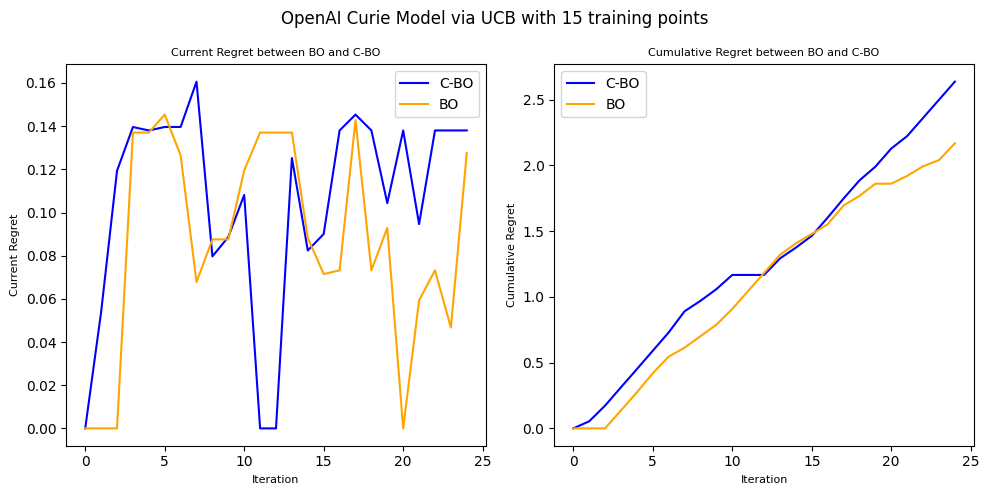

In [129]:
# CEBO with MMR Vs CEBO+Context with MMR

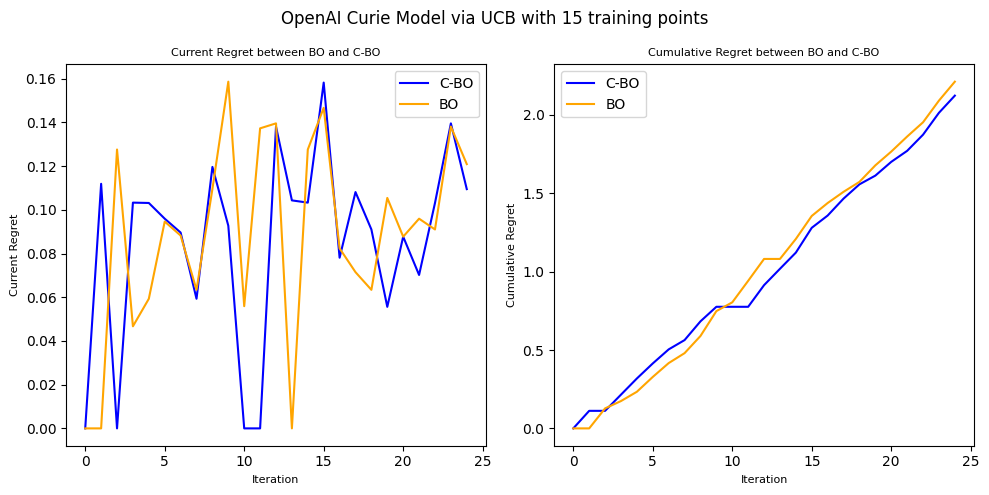

In [131]:
# CEBO with MMR Vs CEBO+Context with MMR

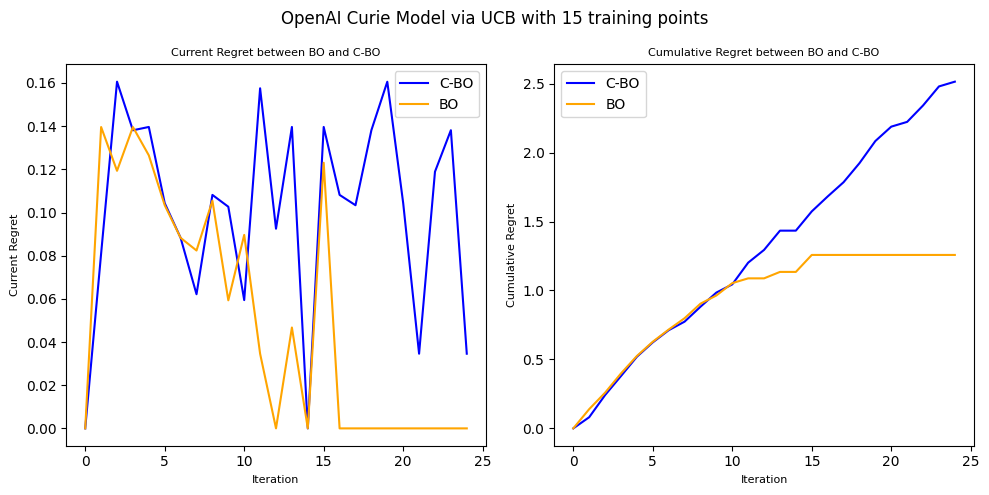

In [13]:
# BO-LIFT with MMR Vs CEBO+Context with MMR

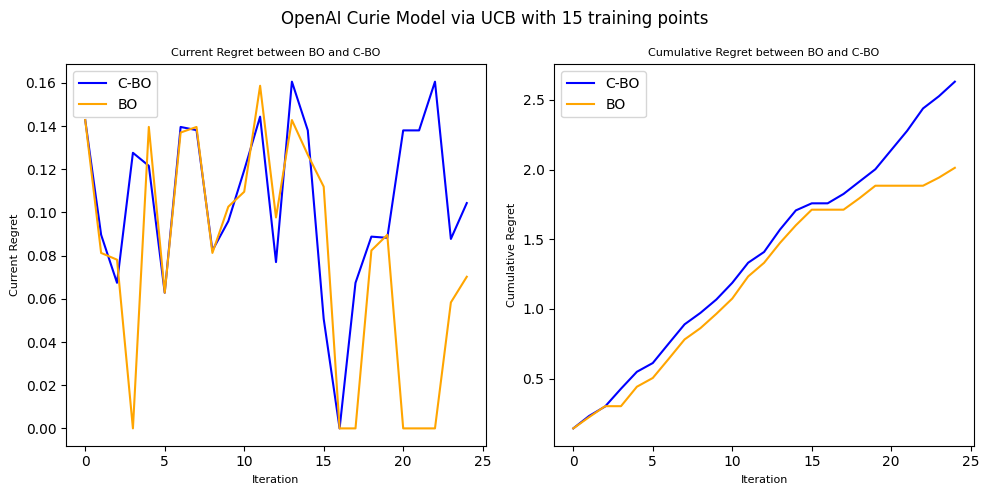

In [64]:
# BO-LIFT with MMR Vs BO-LIFT+Context with MMR

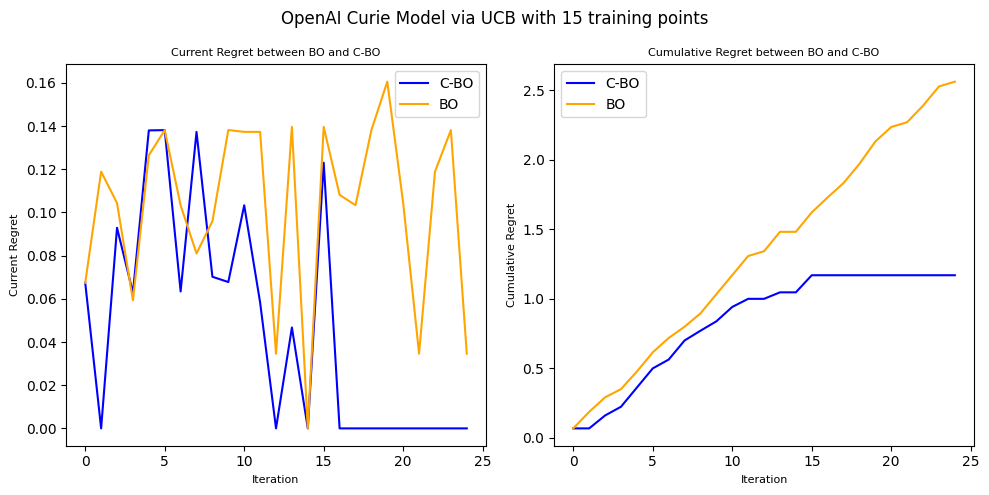

In [74]:
# BO-LIFT with MMR Vs CEBO+Context without MMR

<DIV STYLE="background-color:#000000; height:10px; width:100%;">